In [6]:
import random
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [7]:
class Data:
    def __init__(self, batch_size, workers, image_size):
        dataset = dset.ImageFolder(root='./data/celeba',
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
        
        self.loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

In [8]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
class Experiment:

    manual_seed = 999
    batch_size = 128
    workers = 2
    image_size = 64
    # Number of channels in the training images. For color images this is 3
    nc = 3
    # Size of z latent vector (i.e. size of generator input)
    nz = 100
    # Size of feature maps in generator
    ngf = 64
    # Size of feature maps in discriminator
    ndf = 64
    real_label = 1.
    fake_label = 0.

    def __init__(self):
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        random.seed(self.manual_seed)
        torch.manual_seed(self.manual_seed)

        self.data_loader = Data(self.batch_size, self.workers, self.image_size).loader
        self.total_data = len(self.data_loader)

        self.netG = Generator(self.nz, self.ngf, self.nc).to(self.device)
        self.netG.apply(self.weights_init)
        self.netD = Discriminator(self.ndf, self.nc).to(self.device)
        self.netD.apply(self.weights_init)
        self.optimizerD = torch.optim.Adam(self.netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizerG = torch.optim.Adam(self.netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.criterion = nn.BCELoss()

        self.fixed_noise = torch.randn(64, self.nz, 1, 1, device=self.device)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def run(self, num_epochs):
        img_list = []
        G_losses = []
        D_losses = []
        iters = 0
        for epoch in range(num_epochs):
            for i, data in enumerate(self.data_loader, 0):
                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                self.netD.zero_grad()
                # Format batch
                real_cpu = data[0].to(self.device)
                b_size = real_cpu.size(0)


                label = torch.full((b_size,), self.real_label, dtype=torch.float, device=self.device)
                # Forward pass real batch through D
                output = self.netD(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = self.criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, self.nz, 1, 1, device=self.device)
                # Generate fake image batch with G
                fake = self.netG(noise)
                label.fill_(self.fake_label)
                # Classify all fake batch with D
                output = self.netD(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = self.criterion(output, label)
                # Calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Add the gradients from the all-real and all-fake batches
                errD = errD_real + errD_fake
                # Update D
                self.optimizerD.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                self.netG.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = self.netD(fake).view(-1)
                # Calculate G's loss based on this output
                errG = self.criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                self.optimizerG.step()

                # Output training stats
                if i % 50 == 0:
                    print("[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                        % (epoch, num_epochs, i, self.total_data, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == self.total_data-1)):
                    with torch.no_grad():
                        fake = self.netG(self.fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
        
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(G_losses,label="G")
        plt.plot(D_losses,label="D")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


        fig = plt.figure(figsize=(8,8))
        plt.axis("off")
        ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
        ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

        HTML(ani.to_jshtml())

[0/5][0/1583]	Loss_D: 1.9459	Loss_G: 4.0420	D(x): 0.3908	D(G(z)): 0.4996 / 0.0253
[0/5][50/1583]	Loss_D: 0.2779	Loss_G: 28.0878	D(x): 0.8661	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.2082	Loss_G: 4.5124	D(x): 0.9296	D(G(z)): 0.0838 / 0.0216
[0/5][150/1583]	Loss_D: 0.2880	Loss_G: 5.0926	D(x): 0.8108	D(G(z)): 0.0239 / 0.0145
[0/5][200/1583]	Loss_D: 1.2126	Loss_G: 6.4348	D(x): 0.9461	D(G(z)): 0.5685 / 0.0039
[0/5][250/1583]	Loss_D: 0.4333	Loss_G: 4.4196	D(x): 0.8713	D(G(z)): 0.1202 / 0.0275
[0/5][300/1583]	Loss_D: 0.4073	Loss_G: 4.3268	D(x): 0.8991	D(G(z)): 0.2196 / 0.0274
[0/5][350/1583]	Loss_D: 0.4177	Loss_G: 2.3361	D(x): 0.8452	D(G(z)): 0.1738 / 0.1315
[0/5][400/1583]	Loss_D: 0.7914	Loss_G: 5.7024	D(x): 0.8837	D(G(z)): 0.4170 / 0.0070
[0/5][450/1583]	Loss_D: 0.9407	Loss_G: 2.2566	D(x): 0.5666	D(G(z)): 0.0905 / 0.1632
[0/5][500/1583]	Loss_D: 0.3769	Loss_G: 4.1363	D(x): 0.8375	D(G(z)): 0.1387 / 0.0242
[0/5][550/1583]	Loss_D: 0.5452	Loss_G: 3.2699	D(x): 0.7597	D(G(z)): 0.1231 / 0

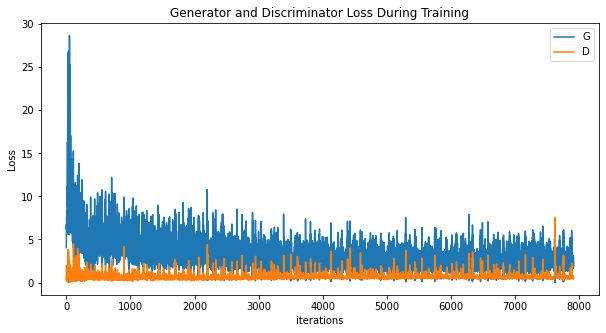

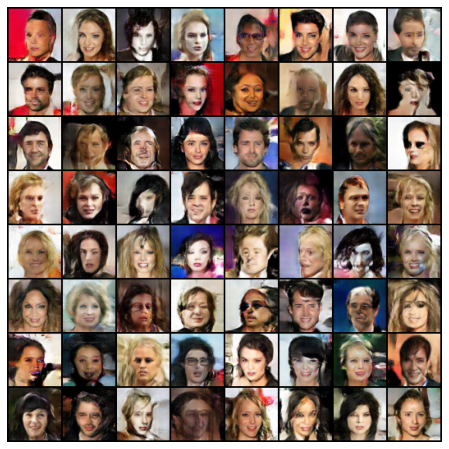

In [10]:
Experiment().run(5)